# Extracting a Time Series

## **Overview**

In this tutorial, we will take MODIS Vegetation Indices Version 6.1 data which are generated every 16 days at 250 meter (m) spatial resolution for 2020 year to get the Normalised Differnece Vegetation Index (NDVI) at different point locations.

Data Credit:

*   Didan, K. (2015). MOD13Q1 MODIS/Terra Vegetation Indices 16-Day L3 Global 250m SIN Grid V061. NASA EOSDIS Land Processes DAAC. Accessed 2023-05 from https://doi.org/10.5067/MODIS/MOD13Q1.006




## Setup and Data Download

The following blocks of code will install the required packages and download the datasets to your Colab environment.

In [1]:
%%capture
if 'google.colab' in str(get_ipython()):
    !apt install libspatialindex-dev
    !pip install fiona shapely pyproj rtree
    !pip install geopandas
    !pip install rioxarray

In [10]:
import datetime
import glob
import os
import re
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
import zipfile

In [3]:
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

In [4]:
def download(url):
    filename = os.path.join(data_folder, os.path.basename(url))
    if not os.path.exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)


filename = 'modis_vegetation_indices_2020.zip'
url = 'https://storage.googleapis.com/spatialthoughts-public-data/' + filename

download(url)

# Data Pre-Processing

First we unzip and extract the images to a folder.

In [46]:
zipfile_path = os.path.join(data_folder, filename)
with zipfile.ZipFile(zipfile_path) as zf:
  zf.extractall(data_folder)

In [60]:
def path_to_datetimeindex(filepath):
  filename = os.path.basename(filepath)
  pattern = r'doy(\d+)'
  match = re.search(pattern, filepath)
  if match:
      doy_value = match.group(1)
      timestamp = datetime.datetime.strptime(doy_value, '%Y%j')
      return timestamp
  else:
    print('Could not extract DOY from filename', filename)


timestamps = []
filepaths = []

files = os.path.join(data_folder, 'modis_vegetation_indices_2020', '*.tif')
for filepath in glob.glob(files):
  timestamp = path_to_datetimeindex(filepath)
  filepaths.append(filepath)
  timestamps.append(timestamp)

unique_timestamps = sorted(set(timestamps))

In [61]:
scenes = []

for timestamp in unique_timestamps:
  ndvi_filepattern = r'NDVI_doy{}'.format(timestamp.strftime('%Y%j'))
  evi_filepattern = r'EVI_doy{}'.format(timestamp.strftime('%Y%j'))

  ndvi_filepath = [filepath for filepath in filepaths if re.search(ndvi_filepattern, filepath)][0]
  evi_filepath = [filepath for filepath in filepaths if re.search(evi_filepattern, filepath)][0]

  ndvi_band = rxr.open_rasterio(ndvi_filepath, chunks={'x':512, 'y':512})
  ndvi_band.name = 'NDVI'
  evi_band = rxr.open_rasterio(evi_filepath, chunks={'x':512, 'y':512})
  evi_band.name = 'EVI'
  bands = [ndvi_band/10000, evi_band/10000]
  scene = xr.merge(bands)
  scenes.append(scene)

In [62]:
time_var = xr.Variable('time', list(unique_timestamps))

time_series_scenes = xr.concat(scenes, dim=time_var)
time_series_scenes

<xarray.Dataset>
Dimensions:      (band: 1, x: 1090, y: 1656, time: 22)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 74.05 74.06 74.06 74.06 ... 78.58 78.58 78.59 78.59
  * y            (y) float64 18.48 18.47 18.47 18.46 ... 11.59 11.59 11.59 11.58
    spatial_ref  int64 0
  * time         (time) datetime64[ns] 2020-01-01 2020-01-17 ... 2020-12-18
Data variables:
    NDVI         (time, band, y, x) float64 dask.array<chunksize=(1, 1, 512, 512), meta=np.ndarray>
    EVI          (time, band, y, x) float64 dask.array<chunksize=(1, 1, 512, 512), meta=np.ndarray>

## Plotting the time-series

In [63]:
time_series = time_series_scenes.interp(y=12.97, x=77.59)

In [64]:
time_series

<xarray.Dataset>
Dimensions:      (band: 1, time: 22)
Coordinates:
  * band         (band) int64 1
    spatial_ref  int64 0
  * time         (time) datetime64[ns] 2020-01-01 2020-01-17 ... 2020-12-18
    y            float64 12.97
    x            float64 77.59
Data variables:
    NDVI         (time, band) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    EVI          (time, band) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>

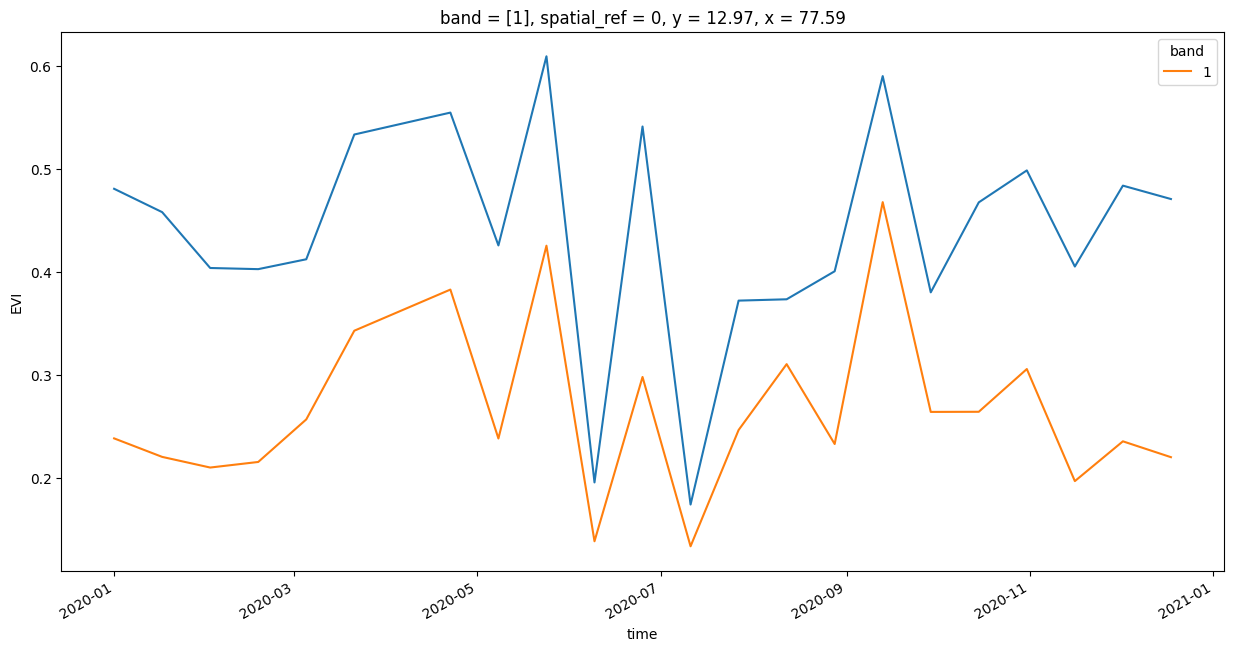

In [65]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15, 7)
time_series.NDVI.plot.line(ax=ax, x='time', hue='band')
time_series.EVI.plot.line(ax=ax, x='time', hue='band')
plt.show()